# Panel EDA and Pre-trends

Validates causal readiness through coverage analysis, pre-trend diagnostics, and outcome distribution checks.

**Inputs:**
- `data/intermediate/did_campaign_panel_purchase.parquet` 
- tables: event study weekly, campaign estimates, panel coverage, overall estimate

**Outputs:**
- Tables: `results/eda/tables/*.csv`
- Figures: `results/eda/figures/*.png`
- Summary: `results/eda/EDA_SUMMARY.md`
- Manifest: `results/run_manifests/eda_manifest_<timestamp>.json`



In [40]:
%matplotlib inline

import os
import sys
import json
import logging
from pathlib import Path
from datetime import datetime, timezone
from typing import Dict, List, Optional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('causal_analytics.notebook03')

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (10, 6)

print(f"Python executable: {sys.executable}")



Python executable: /Users/rajnishpanwar/.venv/bin/python


In [41]:
def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(12):
        if (p / "README.md").exists():
            return p
        p = p.parent
    raise RuntimeError("Repository root not found (README.md missing)")

REPO_ROOT = find_repo_root(Path.cwd())
DATA_DIR = REPO_ROOT / "data" / "intermediate"
OUT_DIR = REPO_ROOT / "results" / "eda"
FIG_DIR = OUT_DIR / "figures"
TABLE_DIR = OUT_DIR / "tables"
RUN_MANIFESTS_DIR = REPO_ROOT / "results" / "run_manifests"

OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)
RUN_MANIFESTS_DIR.mkdir(parents=True, exist_ok=True)

logger.info(f"Repository root: {REPO_ROOT}")



2026-01-14 18:28:34,474 - INFO - Repository root: /Users/rajnishpanwar/Desktop/Casual Analytics


In [42]:
panel_file = DATA_DIR / "did_campaign_panel_purchase.parquet"
if not panel_file.exists():
    raise FileNotFoundError(f"Panel file not found: {panel_file}")

df_panel = pd.read_parquet(panel_file)
logger.info(f"Loaded panel: {len(df_panel)} rows, {len(df_panel.columns)} columns")

print(f"Shape: {df_panel.shape}")
print(f"\nData types:")
print(df_panel.dtypes)
print(f"\nFirst 3 rows:")
print(df_panel.head(3))

optional_files = {
    "did_event_study_weekly_purchase.parquet": "did_event_study_weekly",
    "did_campaign_estimates_purchase.parquet": "did_campaign_estimates",
    "did_campaign_estimates_purchase_valid.parquet": "did_campaign_estimates_valid",
    "did_campaign_estimates_purchase_invalid.parquet": "did_campaign_estimates_invalid",
    "did_panel_coverage_purchase.parquet": "did_panel_coverage",
    "did_overall_estimate_purchase.parquet": "did_overall_estimate"
}

optional_data = {}
for filename, key in optional_files.items():
    filepath = DATA_DIR / filename
    if filepath.exists():
        optional_data[key] = pd.read_parquet(filepath)
        logger.info(f"Loaded optional file: {filename} ({len(optional_data[key])} rows)")
    else:
        logger.warning(f"Optional file not found: {filename}")



2026-01-14 18:28:34,502 - INFO - Loaded panel: 122536 rows, 11 columns
2026-01-14 18:28:34,513 - INFO - Loaded optional file: did_event_study_weekly_purchase.parquet (27183 rows)
2026-01-14 18:28:34,517 - INFO - Loaded optional file: did_campaign_estimates_purchase.parquet (1584 rows)
2026-01-14 18:28:34,522 - INFO - Loaded optional file: did_campaign_estimates_purchase_valid.parquet (9 rows)
2026-01-14 18:28:34,526 - INFO - Loaded optional file: did_campaign_estimates_purchase_invalid.parquet (1575 rows)
2026-01-14 18:28:34,528 - INFO - Loaded optional file: did_panel_coverage_purchase.parquet (1 rows)
2026-01-14 18:28:34,530 - INFO - Loaded optional file: did_overall_estimate_purchase.parquet (1 rows)


Shape: (122536, 11)

Data types:
campaign_id                int64
household_id               int64
week_number                int64
anchor_week                int64
rel_week                   int64
treated                    int64
post                       int64
total_sales_value        float64
total_units              float64
total_coupon_discount    float64
total_retail_discount    float64
dtype: object

First 3 rows:
   campaign_id  household_id  week_number  anchor_week  rel_week  treated  \
0            1             8           61           53         8        1   
1            1             8           60           53         7        1   
2            1             8           59           53         6        1   

   post  total_sales_value  total_units  total_coupon_discount  \
0     1             105.25         42.0                  -3.85   
1     1               0.00          0.0                   0.00   
2     1               0.00          0.0                   0.00   

 

In [43]:
required_cols = ["campaign_id", "household_id", "week_number", "rel_week", "anchor_week", "treated", "post"]
missing_cols = [col for col in required_cols if col not in df_panel.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

required_outcomes = ["total_sales_value", "total_units"]
missing_outcomes = [col for col in required_outcomes if col not in df_panel.columns]
if missing_outcomes:
    raise ValueError(f"Missing required outcome columns: {missing_outcomes}")

for col in required_cols:
    null_count = df_panel[col].isnull().sum()
    if null_count > 0:
        raise ValueError(f"Column {col} has {null_count} null values")

df_panel["treated"] = pd.to_numeric(df_panel["treated"], errors="coerce").fillna(0).astype(int)
df_panel["post"] = pd.to_numeric(df_panel["post"], errors="coerce").fillna(0).astype(int)

if not df_panel["treated"].isin([0, 1]).all():
    raise ValueError("treated column must be 0 or 1")
if not df_panel["post"].isin([0, 1]).all():
    raise ValueError("post column must be 0 or 1")

treated_post_crosstab_rows = pd.crosstab(df_panel["treated"], df_panel["post"], margins=True)
print("2x2 Structure (by row counts):")
print(treated_post_crosstab_rows)

distinct_households = {}
for t in [0, 1]:
    for p in [0, 1]:
        subset = df_panel[(df_panel["treated"] == t) & (df_panel["post"] == p)]
        distinct_households[f"treated_{t}_post_{p}"] = subset["household_id"].nunique()

treated_post_crosstab_hh_dict = {
    "treated_0_post_0": distinct_households["treated_0_post_0"],
    "treated_0_post_1": distinct_households["treated_0_post_1"],
    "treated_1_post_0": distinct_households["treated_1_post_0"],
    "treated_1_post_1": distinct_households["treated_1_post_1"]
}

print("\n2x2 Structure (by distinct households):")
for k, v in treated_post_crosstab_hh_dict.items():
    print(f"  {k}: {v}")

if treated_post_crosstab_rows.loc[0, 0] == 0 or treated_post_crosstab_rows.loc[0, 1] == 0 or treated_post_crosstab_rows.loc[1, 0] == 0 or treated_post_crosstab_rows.loc[1, 1] == 0:
    raise ValueError("2x2 structure has zero cells - cannot proceed")

treated_post_crosstab_rows.to_csv(TABLE_DIR / "treated_post_2x2_counts_rows.csv")
pd.DataFrame([treated_post_crosstab_hh_dict]).to_csv(TABLE_DIR / "treated_post_2x2_counts_households.csv", index=False)

logger.info("Data quality gates passed")



2026-01-14 18:28:34,575 - INFO - Data quality gates passed


2x2 Structure (by row counts):
post         0      1     All
treated                      
0        57256  64413  121669
1          408    459     867
All      57664  64872  122536

2x2 Structure (by distinct households):
  treated_0_post_0: 30
  treated_0_post_1: 30
  treated_1_post_0: 15
  treated_1_post_1: 15


## Coverage Deep Dive



Campaign coverage (first 5):
   campaign_id  n_rows  n_households  treated_share  pre_rows  post_rows  \
0            1     136             8       0.500000        64         72   
1            2      17             1       0.000000         8          9   
2            3      51             3       0.666667        24         27   
3            4      17             1       1.000000         8          9   
4            6      68             4       0.000000        32         36   

   rel_week_min  rel_week_max  
0            -8             8  
1            -8             8  
2            -8             8  
3            -8             8  
4            -8             8  

Top 5 households by rows:
    household_id  n_campaigns  n_rows  share_of_panel_rows
17            18         1133   19261             0.157186
12            13         1077   18309             0.149417
7              8         1076   18292             0.149279
29            30          361    6137             0.050083


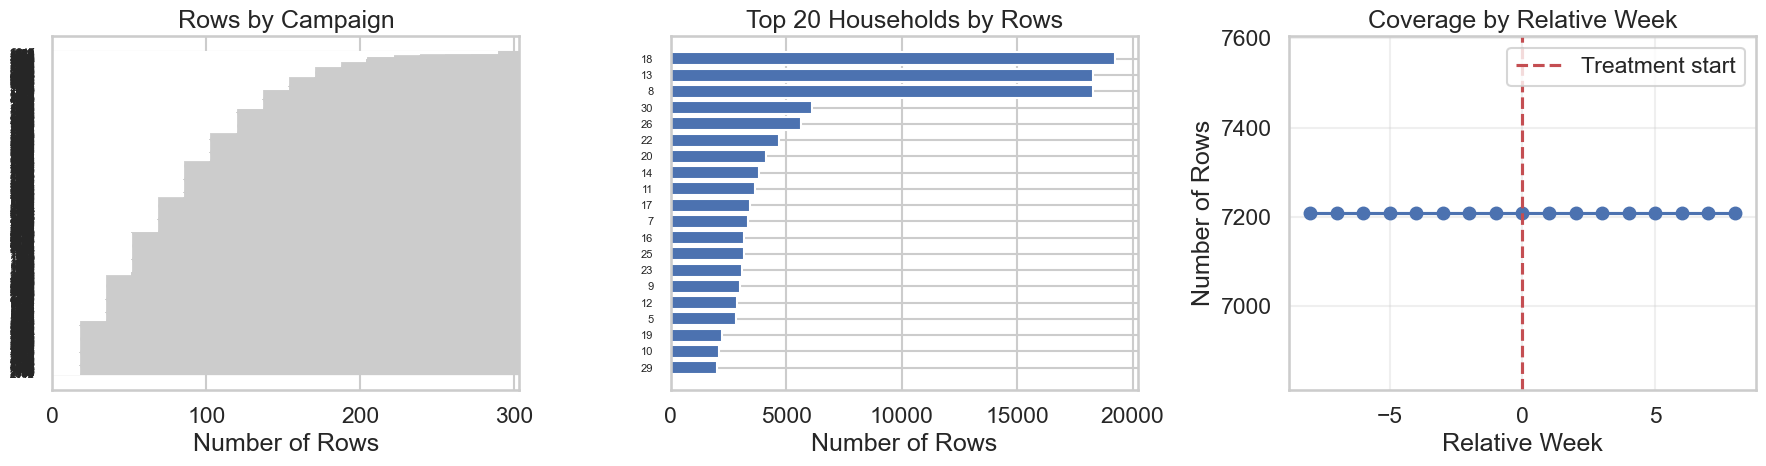

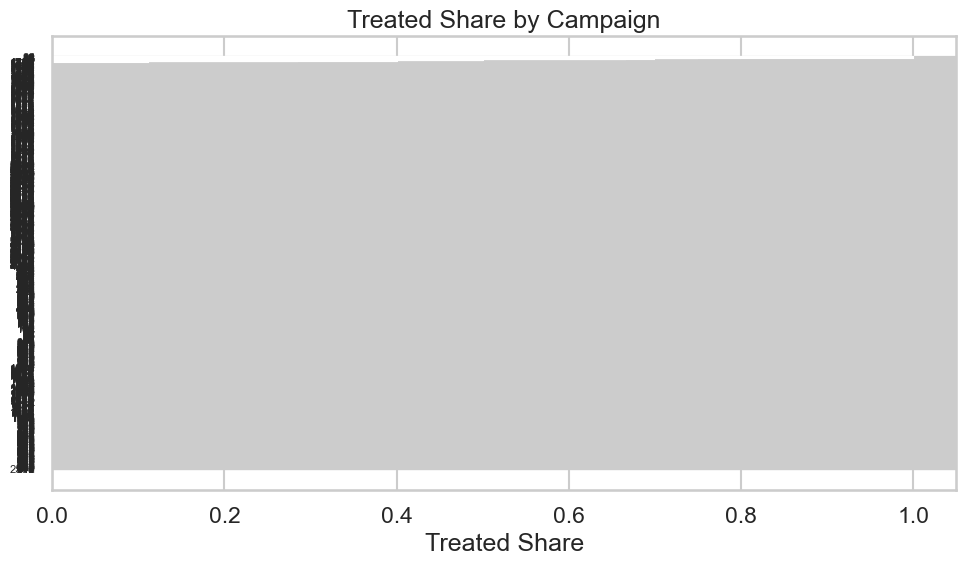

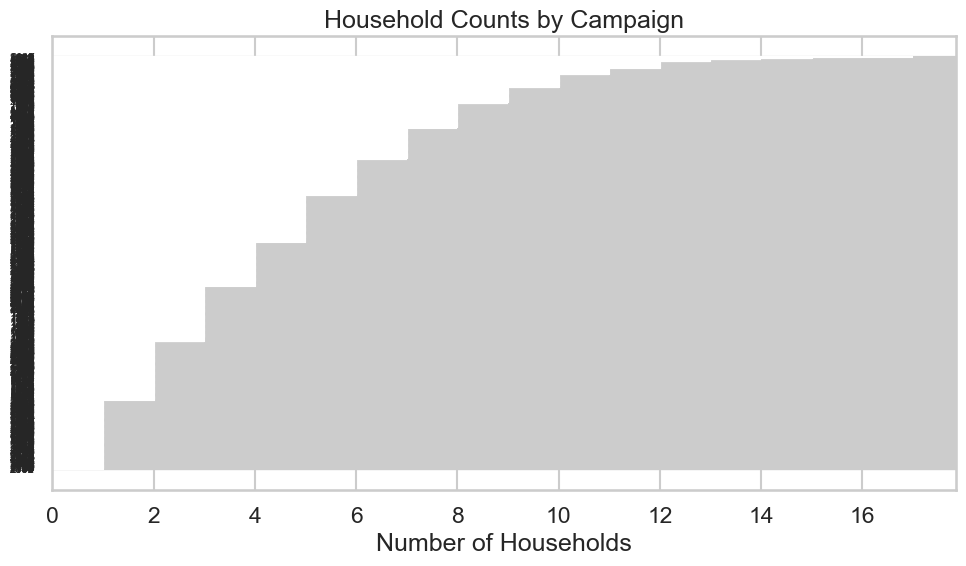

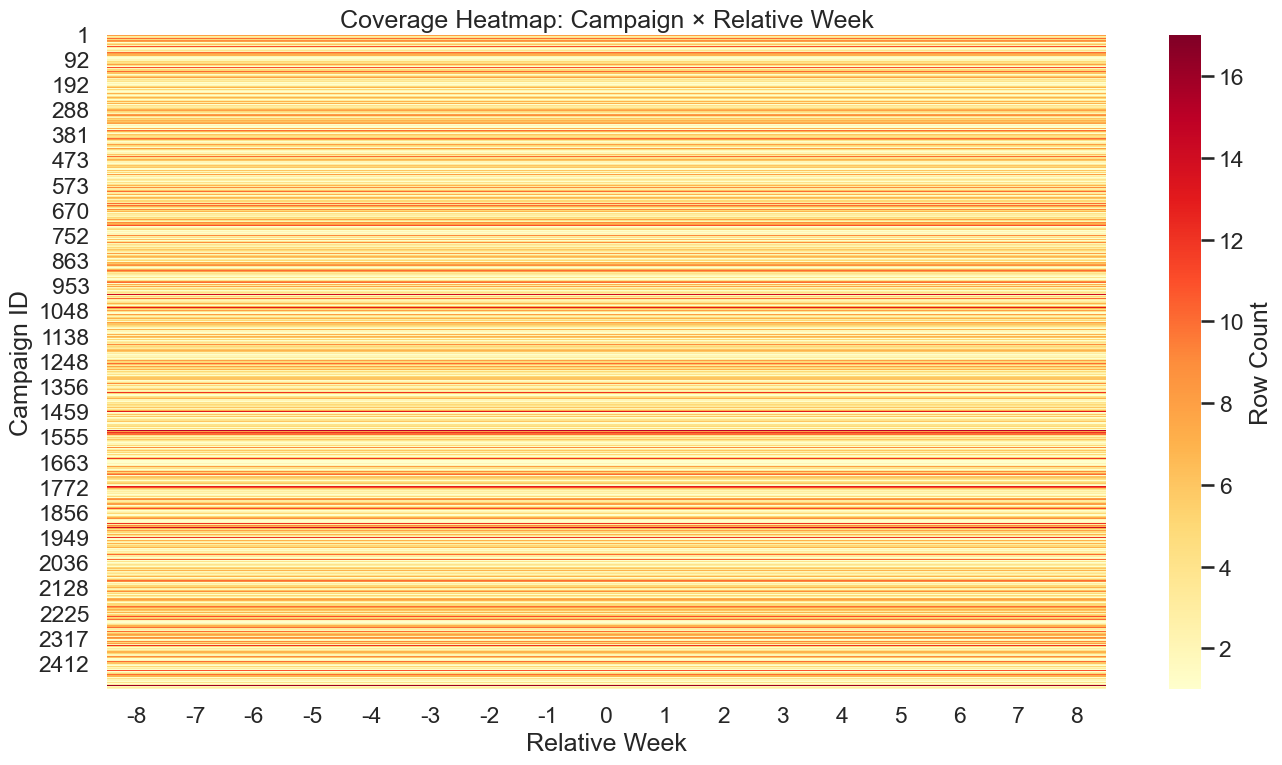

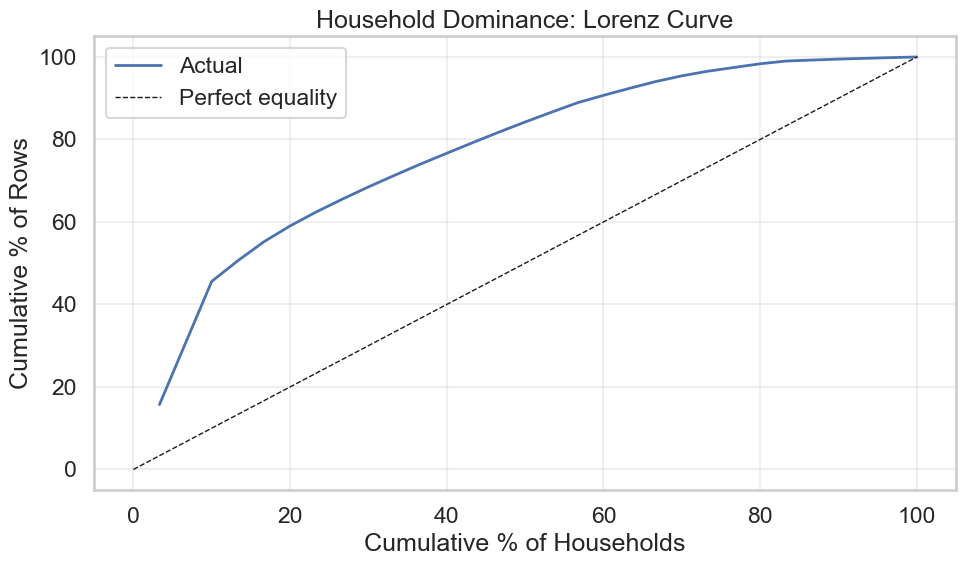

2026-01-14 18:28:52,127 - INFO - Coverage analysis complete


In [44]:
campaign_coverage = df_panel.groupby("campaign_id").agg({
    "household_id": ["count", "nunique"],
    "treated": "mean",
    "week_number": ["min", "max"],
    "rel_week": ["min", "max"],
    "post": lambda x: (x == 0).sum()
}).reset_index()
campaign_coverage.columns = ["campaign_id", "n_rows", "n_households", "treated_share", "week_min", "week_max", "rel_week_min", "rel_week_max", "pre_rows"]
campaign_coverage["post_rows"] = campaign_coverage["n_rows"] - campaign_coverage["pre_rows"]
campaign_coverage = campaign_coverage[["campaign_id", "n_rows", "n_households", "treated_share", "pre_rows", "post_rows", "rel_week_min", "rel_week_max"]]
campaign_coverage.to_csv(TABLE_DIR / "campaign_coverage_table.csv", index=False)
print("Campaign coverage (first 5):")
print(campaign_coverage.head())

campaign_2x2_completeness = []
for camp_id in df_panel["campaign_id"].unique():
    sub = df_panel[df_panel["campaign_id"] == camp_id]
    has_ctrl_pre = len(sub[(sub["treated"] == 0) & (sub["post"] == 0)]) > 0
    has_ctrl_post = len(sub[(sub["treated"] == 0) & (sub["post"] == 1)]) > 0
    has_treat_pre = len(sub[(sub["treated"] == 1) & (sub["post"] == 0)]) > 0
    has_treat_post = len(sub[(sub["treated"] == 1) & (sub["post"] == 1)]) > 0
    campaign_2x2_completeness.append({
        "campaign_id": camp_id,
        "has_ctrl_pre": int(has_ctrl_pre),
        "has_ctrl_post": int(has_ctrl_post),
        "has_treat_pre": int(has_treat_pre),
        "has_treat_post": int(has_treat_post),
        "ctrl_pre_rows": len(sub[(sub["treated"] == 0) & (sub["post"] == 0)]),
        "ctrl_post_rows": len(sub[(sub["treated"] == 0) & (sub["post"] == 1)]),
        "treat_pre_rows": len(sub[(sub["treated"] == 1) & (sub["post"] == 0)]),
        "treat_post_rows": len(sub[(sub["treated"] == 1) & (sub["post"] == 1)])
    })
df_completeness = pd.DataFrame(campaign_2x2_completeness)
df_completeness.to_csv(TABLE_DIR / "campaign_2x2_completeness.csv", index=False)

household_dominance = df_panel.groupby("household_id").agg({
    "campaign_id": "nunique",
    "week_number": "count"
}).reset_index()
household_dominance.columns = ["household_id", "n_campaigns", "n_rows"]
household_dominance = household_dominance.sort_values("n_rows", ascending=False)
household_dominance["share_of_panel_rows"] = household_dominance["n_rows"] / len(df_panel)
household_dominance.to_csv(TABLE_DIR / "top_households_by_rows.csv", index=False)
print("\nTop 5 households by rows:")
print(household_dominance.head())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
campaign_coverage_sorted = campaign_coverage.sort_values("n_rows", ascending=False)
axes[0].barh(range(len(campaign_coverage_sorted)), campaign_coverage_sorted["n_rows"])
axes[0].set_yticks(range(len(campaign_coverage_sorted)))
axes[0].set_yticklabels(campaign_coverage_sorted["campaign_id"], fontsize=8)
axes[0].set_xlabel("Number of Rows")
axes[0].set_title("Rows by Campaign")
axes[0].invert_yaxis()

household_dominance_top = household_dominance.head(20)
axes[1].barh(range(len(household_dominance_top)), household_dominance_top["n_rows"])
axes[1].set_yticks(range(len(household_dominance_top)))
axes[1].set_yticklabels(household_dominance_top["household_id"], fontsize=8)
axes[1].set_xlabel("Number of Rows")
axes[1].set_title("Top 20 Households by Rows")
axes[1].invert_yaxis()

rel_week_coverage = df_panel.groupby("rel_week").size()
axes[2].plot(rel_week_coverage.index, rel_week_coverage.values, marker='o')
axes[2].axvline(x=0, color='r', linestyle='--', label='Treatment start')
axes[2].set_xlabel("Relative Week")
axes[2].set_ylabel("Number of Rows")
axes[2].set_title("Coverage by Relative Week")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "panel_coverage_overview.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(10, 6))
campaign_coverage_sorted = campaign_coverage.sort_values("treated_share", ascending=False)
ax.barh(range(len(campaign_coverage_sorted)), campaign_coverage_sorted["treated_share"])
ax.set_yticks(range(len(campaign_coverage_sorted)))
ax.set_yticklabels(campaign_coverage_sorted["campaign_id"], fontsize=8)
ax.set_xlabel("Treated Share")
ax.set_title("Treated Share by Campaign")
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(FIG_DIR / "treated_share_by_campaign.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(10, 6))
campaign_coverage_sorted = campaign_coverage.sort_values("n_households", ascending=False)
ax.barh(range(len(campaign_coverage_sorted)), campaign_coverage_sorted["n_households"])
ax.set_yticks(range(len(campaign_coverage_sorted)))
ax.set_yticklabels(campaign_coverage_sorted["campaign_id"], fontsize=8)
ax.set_xlabel("Number of Households")
ax.set_title("Household Counts by Campaign")
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(FIG_DIR / "campaign_household_counts.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

coverage_heatmap_data = df_panel.groupby(["campaign_id", "rel_week"]).size().unstack(fill_value=0)
coverage_heatmap_data.to_csv(TABLE_DIR / "coverage_heatmap_matrix.csv")
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(coverage_heatmap_data, cmap="YlOrRd", cbar_kws={'label': 'Row Count'}, ax=ax)
ax.set_xlabel("Relative Week")
ax.set_ylabel("Campaign ID")
ax.set_title("Coverage Heatmap: Campaign × Relative Week")
plt.tight_layout()
plt.savefig(FIG_DIR / "coverage_heatmap_campaign_by_relweek.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

household_dominance_sorted = household_dominance.sort_values("n_rows", ascending=False)
household_dominance_sorted["cum_pct_households"] = (np.arange(len(household_dominance_sorted)) + 1) / len(household_dominance_sorted) * 100
household_dominance_sorted["cum_pct_rows"] = household_dominance_sorted["share_of_panel_rows"].cumsum() * 100
lorenz_data = household_dominance_sorted[["cum_pct_households", "cum_pct_rows"]].copy()
lorenz_data.to_csv(TABLE_DIR / "household_dominance_curve.csv", index=False)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lorenz_data["cum_pct_households"], lorenz_data["cum_pct_rows"], linewidth=2, label='Actual')
ax.plot([0, 100], [0, 100], 'k--', linewidth=1, label='Perfect equality')
ax.set_xlabel("Cumulative % of Households")
ax.set_ylabel("Cumulative % of Rows")
ax.set_title("Household Dominance: Lorenz Curve")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "household_dominance_lorenz.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

logger.info("Coverage analysis complete")



Panel basic stats:
   n_rows  n_households  n_campaigns  treated_share  week_number_min  \
0  122536            30         1584       0.007075               -7   

   week_number_max  rel_week_min  rel_week_max  
0              104            -8             8  

Sales percentiles (1, 5, 50, 95, 99):
0.01      0.00
0.05      0.00
0.50      0.00
0.95     14.92
0.99    109.37
Name: total_sales_value, dtype: float64

Units percentiles (1, 5, 50, 95, 99):
0.01     0.0
0.05     0.0
0.50     0.0
0.95     9.0
0.99    42.0
Name: total_units, dtype: float64


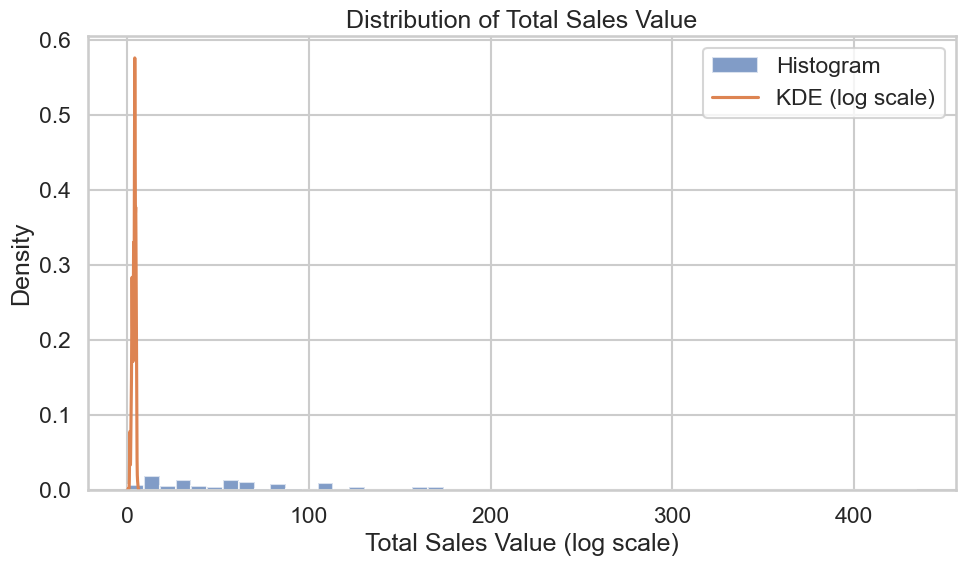

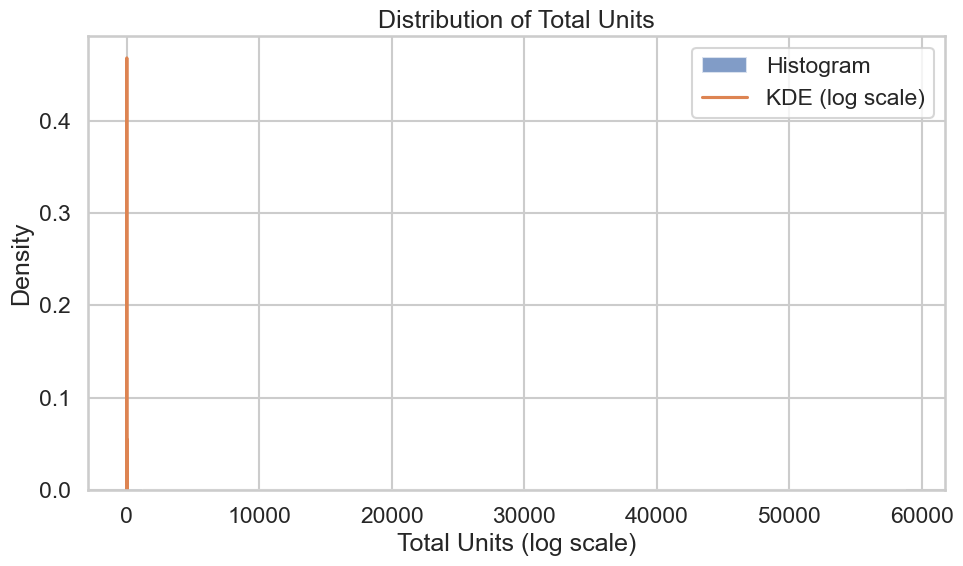

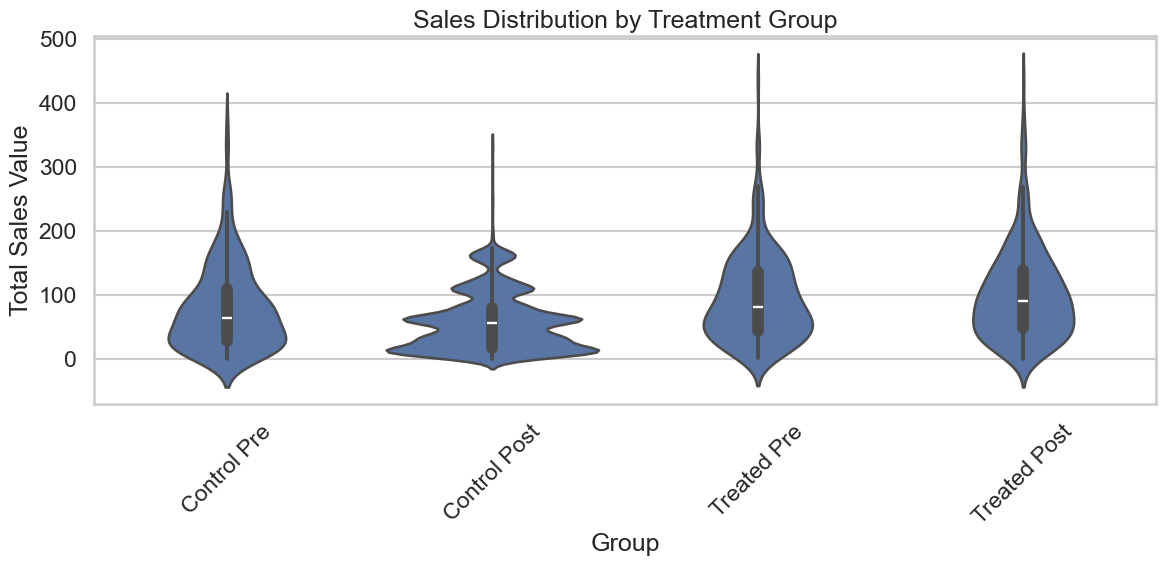

2026-01-14 18:28:52,920 - INFO - Outcome distributions complete


In [45]:
n_rows = len(df_panel)
n_households = df_panel["household_id"].nunique()
n_campaigns = df_panel["campaign_id"].nunique()
treated_share = df_panel["treated"].mean()
week_min = df_panel["week_number"].min()
week_max = df_panel["week_number"].max()
rel_week_min = df_panel["rel_week"].min()
rel_week_max = df_panel["rel_week"].max()

panel_basic_stats = pd.DataFrame([{
    "n_rows": n_rows,
    "n_households": n_households,
    "n_campaigns": n_campaigns,
    "treated_share": treated_share,
    "week_number_min": week_min,
    "week_number_max": week_max,
    "rel_week_min": rel_week_min,
    "rel_week_max": rel_week_max
}])
panel_basic_stats.to_csv(TABLE_DIR / "panel_basic_stats.csv", index=False)
print("Panel basic stats:")
print(panel_basic_stats)

sales_percentiles = df_panel["total_sales_value"].quantile([0.01, 0.05, 0.50, 0.95, 0.99])
units_percentiles = df_panel["total_units"].quantile([0.01, 0.05, 0.50, 0.95, 0.99])
print("\nSales percentiles (1, 5, 50, 95, 99):")
print(sales_percentiles)
print("\nUnits percentiles (1, 5, 50, 95, 99):")
print(units_percentiles)

fig, ax = plt.subplots(figsize=(10, 6))
sales_positive = df_panel[df_panel["total_sales_value"] > 0]["total_sales_value"]
ax.hist(sales_positive, bins=50, density=True, alpha=0.7, label='Histogram')
sales_positive_log = np.log1p(sales_positive)
sns.kdeplot(data=pd.DataFrame({"log_sales": sales_positive_log}), x="log_sales", ax=ax, label='KDE (log scale)')
ax.set_xlabel("Total Sales Value (log scale)")
ax.set_ylabel("Density")
ax.set_title("Distribution of Total Sales Value")
ax.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "outcome_distribution_sales.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(10, 6))
units_positive = df_panel[df_panel["total_units"] > 0]["total_units"]
ax.hist(units_positive, bins=50, density=True, alpha=0.7, label='Histogram')
units_positive_log = np.log1p(units_positive)
sns.kdeplot(data=pd.DataFrame({"log_units": units_positive_log}), x="log_units", ax=ax, label='KDE (log scale)')
ax.set_xlabel("Total Units (log scale)")
ax.set_ylabel("Density")
ax.set_title("Distribution of Total Units")
ax.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "outcome_distribution_units.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

df_panel["group"] = df_panel["treated"].astype(str) + "_" + df_panel["post"].astype(str)
group_labels = {"0_0": "Control Pre", "0_1": "Control Post", "1_0": "Treated Pre", "1_1": "Treated Post"}
df_panel["group_label"] = df_panel["group"].map(group_labels)
sales_positive_groups = df_panel[df_panel["total_sales_value"] > 0].copy()
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(data=sales_positive_groups, x="group_label", y="total_sales_value", ax=ax, order=list(group_labels.values()))
ax.set_xlabel("Group")
ax.set_ylabel("Total Sales Value")
ax.set_title("Sales Distribution by Treatment Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / "sales_distribution_by_group_violin.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

logger.info("Outcome distributions complete")



## Pre-trends / Event-study Style EDA



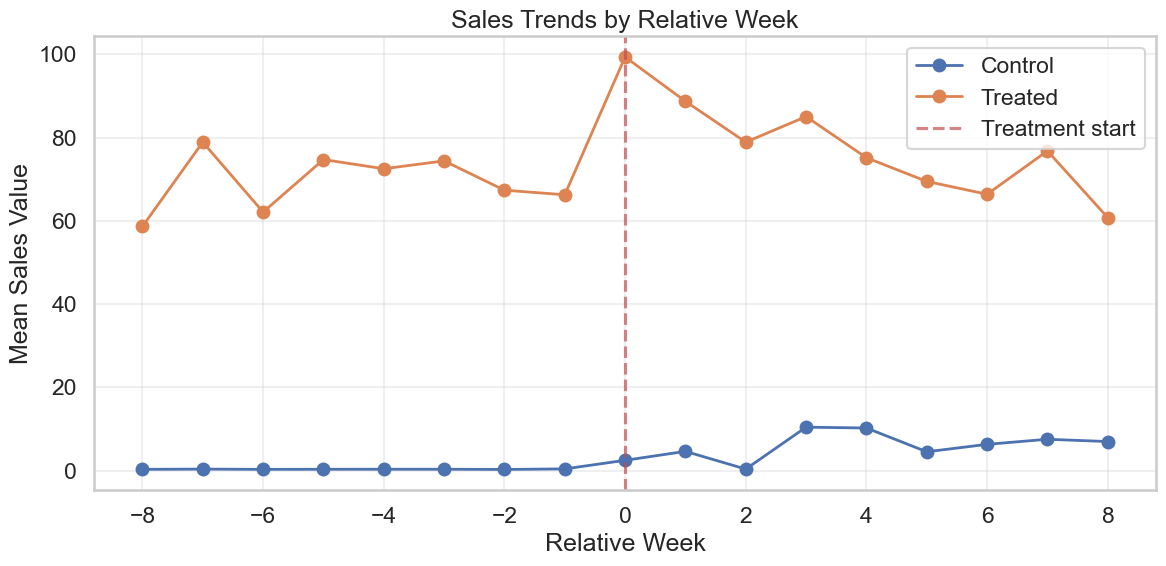

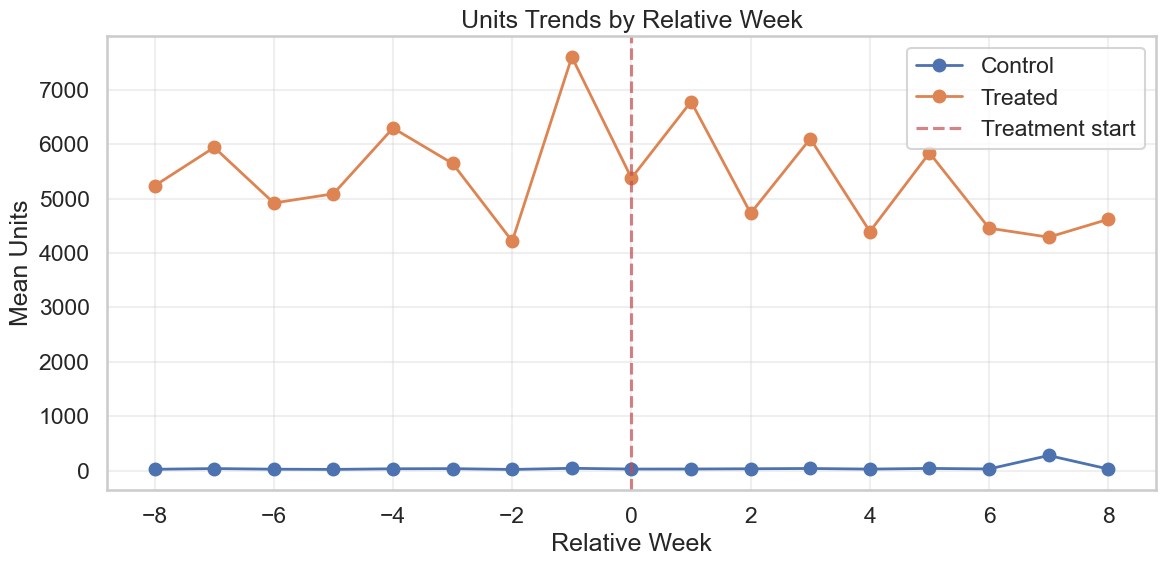

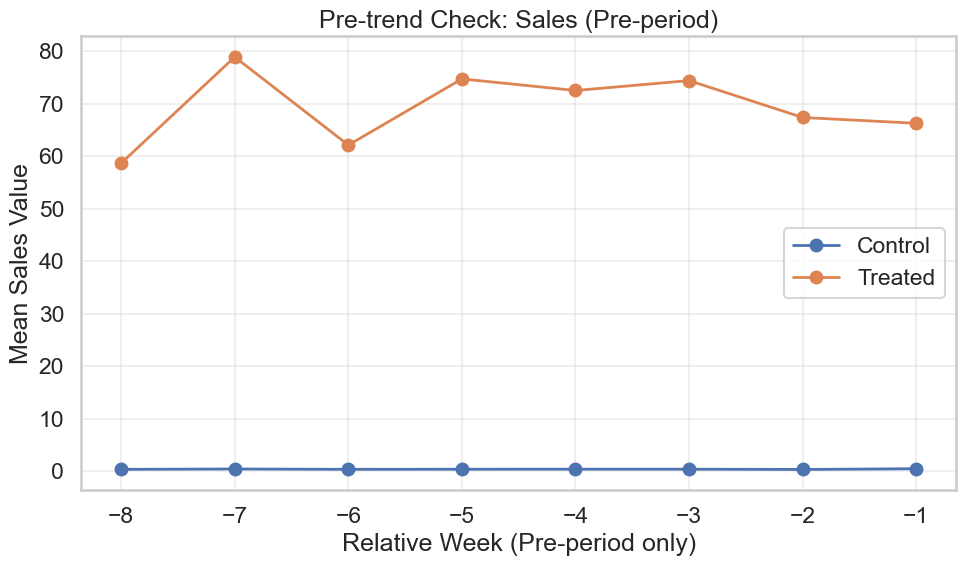

2026-01-14 18:28:53,509 - INFO - Pre-trend analysis complete


In [46]:
rel_week_summary_sales = df_panel.groupby(["rel_week", "treated"]).agg({
    "household_id": ["count", "nunique"],
    "total_sales_value": ["mean", "median"]
}).reset_index()
rel_week_summary_sales.columns = ["rel_week", "treated", "n_rows", "n_households", "mean_sales", "median_sales"]
rel_week_summary_sales["treated"] = rel_week_summary_sales["treated"].astype(int)
rel_week_summary_sales.to_csv(TABLE_DIR / "rel_week_summary_sales.csv", index=False)

rel_week_summary_units = df_panel.groupby(["rel_week", "treated"]).agg({
    "household_id": ["count", "nunique"],
    "total_units": ["mean", "median"]
}).reset_index()
rel_week_summary_units.columns = ["rel_week", "treated", "n_rows", "n_households", "mean_units", "median_units"]
rel_week_summary_units["treated"] = rel_week_summary_units["treated"].astype(int)
rel_week_summary_units.to_csv(TABLE_DIR / "rel_week_summary_units.csv", index=False)

fig, ax = plt.subplots(figsize=(12, 6))
for treated_val in [0, 1]:
    subset = rel_week_summary_sales[rel_week_summary_sales["treated"] == treated_val]
    label = "Treated" if treated_val == 1 else "Control"
    ax.plot(subset["rel_week"], subset["mean_sales"], marker='o', label=label, linewidth=2)
ax.axvline(x=0, color='r', linestyle='--', alpha=0.7, label='Treatment start')
ax.set_xlabel("Relative Week")
ax.set_ylabel("Mean Sales Value")
ax.set_title("Sales Trends by Relative Week")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "rel_week_outcome_trends_sales.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(12, 6))
for treated_val in [0, 1]:
    subset = rel_week_summary_units[rel_week_summary_units["treated"] == treated_val]
    label = "Treated" if treated_val == 1 else "Control"
    ax.plot(subset["rel_week"], subset["mean_units"], marker='o', label=label, linewidth=2)
ax.axvline(x=0, color='r', linestyle='--', alpha=0.7, label='Treatment start')
ax.set_xlabel("Relative Week")
ax.set_ylabel("Mean Units")
ax.set_title("Units Trends by Relative Week")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "rel_week_outcome_trends_units.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

pretrend_data = rel_week_summary_sales[rel_week_summary_sales["rel_week"] < 0].copy()
fig, ax = plt.subplots(figsize=(10, 6))
for treated_val in [0, 1]:
    subset = pretrend_data[pretrend_data["treated"] == treated_val]
    label = "Treated" if treated_val == 1 else "Control"
    ax.plot(subset["rel_week"], subset["mean_sales"], marker='o', label=label, linewidth=2)
ax.set_xlabel("Relative Week (Pre-period only)")
ax.set_ylabel("Mean Sales Value")
ax.set_title("Pre-trend Check: Sales (Pre-period)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "pretrend_check_eventstudy_style_sales.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

logger.info("Pre-trend analysis complete")



## Write EDA Summary



In [47]:
n_complete_2x2 = df_completeness[
    (df_completeness["has_ctrl_pre"] == 1) & 
    (df_completeness["has_ctrl_post"] == 1) &
    (df_completeness["has_treat_pre"] == 1) &
    (df_completeness["has_treat_post"] == 1)
].shape[0]

top_household_share = household_dominance.head(1)["share_of_panel_rows"].values[0] if len(household_dominance) > 0 else 0
top_campaign_share = (campaign_coverage.sort_values("n_rows", ascending=False).head(1)["n_rows"].values[0] / n_rows) if len(campaign_coverage) > 0 else 0

summary_md = f"""# Panel EDA Summary

## Dataset Size
- Rows: {n_rows:,}
- Households: {n_households:,}
- Campaigns: {n_campaigns:,}
- Treated share: {treated_share:.2%}

## Coverage and Completeness
- Campaigns with complete 2x2 structure: {n_complete_2x2} of {len(df_completeness)}
- Top household accounts for {top_household_share:.2%} of rows
- Top campaign accounts for {top_campaign_share:.2%} of rows

## Pre-trend Assessment
Based on visual inspection of pre-period trends (rel_week < 0):
- Sales: Trends shown in `pretrend_check_eventstudy_style_sales.png`
- Units: Trends shown in pre-period section of `rel_week_outcome_trends_units.png`
- Interpretation: See plots for visual assessment of parallel trends assumption.

## Notes
- All required outputs saved to `results/eda/tables/` and `results/eda/figures/`
- See individual CSV tables for detailed statistics
"""

with open(OUT_DIR / "EDA_SUMMARY.md", "w") as f:
    f.write(summary_md)

logger.info("EDA summary written")



2026-01-14 18:28:53,518 - INFO - EDA summary written


## Run Manifest



In [48]:
def get_package_versions() -> Dict[str, str]:
    versions = {}
    for pkg in ["pandas", "numpy", "matplotlib", "seaborn"]:
        try:
            mod = __import__(pkg)
            versions[pkg] = getattr(mod, "__version__", "unknown")
        except ImportError:
            versions[pkg] = "not_installed"
    return versions

output_files = [
    str(FIG_DIR / "panel_coverage_overview.png"),
    str(FIG_DIR / "treated_share_by_campaign.png"),
    str(FIG_DIR / "campaign_household_counts.png"),
    str(FIG_DIR / "outcome_distribution_sales.png"),
    str(FIG_DIR / "outcome_distribution_units.png"),
    str(FIG_DIR / "rel_week_outcome_trends_sales.png"),
    str(FIG_DIR / "rel_week_outcome_trends_units.png"),
    str(FIG_DIR / "pretrend_check_eventstudy_style_sales.png"),
    str(TABLE_DIR / "panel_basic_stats.csv"),
    str(TABLE_DIR / "treated_post_2x2_counts_rows.csv"),
    str(TABLE_DIR / "treated_post_2x2_counts_households.csv"),
    str(TABLE_DIR / "campaign_coverage_table.csv"),
    str(TABLE_DIR / "campaign_2x2_completeness.csv"),
    str(TABLE_DIR / "top_households_by_rows.csv"),
    str(TABLE_DIR / "rel_week_summary_sales.csv"),
    str(TABLE_DIR / "rel_week_summary_units.csv"),
    str(OUT_DIR / "EDA_SUMMARY.md")
]

manifest = {
    "timestamp_utc": datetime.now(timezone.utc).isoformat(),
    "python_executable": sys.executable,
    "package_versions": get_package_versions(),
    "input_files": [str(panel_file)] + [str(DATA_DIR / f) for f in optional_files.keys() if (DATA_DIR / f).exists()],
    "output_files": output_files,
    "key_stats": {
        "n_rows": int(n_rows),
        "n_households": int(n_households),
        "n_campaigns": int(n_campaigns),
        "treated_share": float(treated_share)
    },
    "campaign_completeness": {
        "n_complete_2x2": int(n_complete_2x2),
        "n_total_campaigns": int(len(df_completeness))
    },
    "dominance_metrics": {
        "top_household_share": float(top_household_share),
        "top_campaign_share": float(top_campaign_share)
    }
}

manifest_path = RUN_MANIFESTS_DIR / f"eda_manifest_{datetime.now(timezone.utc).strftime('%Y%m%d_%H%M%S')}.json"
with open(manifest_path, "w") as f:
    json.dump(manifest, f, indent=2)

logger.info(f"Manifest saved to {manifest_path}")



2026-01-14 18:28:53,526 - INFO - Manifest saved to /Users/rajnishpanwar/Desktop/Casual Analytics/results/run_manifests/eda_manifest_20260114_182853.json


## Next Steps

- **Next notebook:** `notebooks/eda/modeling/04_uplift_modeling.ipynb`
- **Decision gate:** If pre-trends show significant divergence or dominance metrics indicate extreme concentration, revisit design/filters before proceeding to uplift modeling.

